# Section 3
Create a daily sales forecast by channel for the next 90 days.
- Explain which method you chose and why.
- Explain how you evaluated your results.
- Summarize the accuracy of the forecast.

## Load

In [1]:
import pandas as pd
from datetime import date

# load raw data
df = pd.read_csv(
    'ecom_data.csv',
    dtype={
        'SalesOrder': str,
        'SKU': str,
        'Description': str,
        'UnitPrice': float,
        'CustomerID': int,
        'Channel': str,
        'State': str,
        'Sales': float,
        'Quantity': int
    },
    converters={
        'InvoiceDay': date.fromisoformat
    })

# drop duplicates
df.drop_duplicates(inplace=True)

# restrict to sales
df = df[df.Quantity > 0].reset_index(drop=True)

## Initial Thoughts

Before diving into modeling, let's re-examine the 10 day rolling average for daily sales by channel.

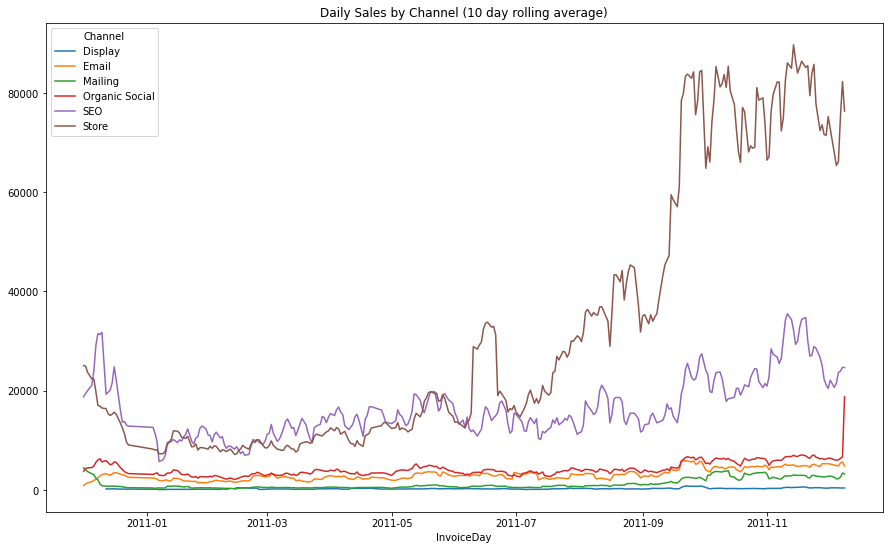

In [2]:
df_rolling = df.groupby(['Channel', 'InvoiceDay'])\
                .agg({'Sales': 'sum'})\
                .rolling(10)\
                .mean()\
                .dropna()

df_rolling.reset_index(drop=False)\
    .pivot(index='InvoiceDay', columns='Channel', values='Sales')\
    .plot(figsize=(15, 9), title="Daily Sales by Channel (10 day rolling average)");

We can tell that there's a clear upward trend for store and mailing sales, while it's less clear if the other channels exhibit upward sales growth.

Because of the clear differences in sales per channel, we'll want to consider using a hierarchical model to forecast sales - one model for each channel, whose results we could aggregate to an overall sales forcast.

Given the limited nature of the dataset and its relatively small time window (less than 1 years' worth of data isn't enough to find an accurate estimate for the seasonal effect), we'll take a simple approach and fit a sinusoidal curve with a linear trend that should reasonably project sales for the next 90 days.

While we could try to use a more complex model like SARIMAX for our forecast, there simply isn't enough data to justify it. Let's create the function and plot a fitted curve (note that we'll keep using `Store` sales for now).

We'll use `scipy.optimize.curve_fit` to fit our curve, and we'll use MAPE and RMSE to measure how well it fits the data. `scipy.optimize.curve_fit` uses non-linear least squares to fit a function, which is what we want as we're fitting a curve. MAPE and RMSE are common measures of model fit, and we'll use them to compare how well different curves fit the data.

In [5]:
import numpy as np
from scipy import optimize

def curve_func(x, amp, freq, phase, trend):
    """Function for a sinusoidal curve with a linear trend component.
    
    ARGS
    - amp: Amplitude of wave.
    - freq: Frequency of wave.
    - phase: Phase shift of wave.
    - trend: Linear trend component.
    
    RETURN
    - Point along the curve given the args above.
    
    """
    return amp * np.sin(freq * x + phase) + trend * x

def fit_curve_func(x, y, p0=[1,1,0,0], curve_func=curve_func):
    """Get parameters, MAPE and RMSE for optimize.curve_fit(curve_func, x, y, p0).
    
    ARGS
    - x: The independant variable.
    - y: The dependant variable.
    - p0: Initial values for the curve_func parameters.
    - curve_func: The curve function to fit.
    
    RETURN
    - dict of parameters, MAPE and RMSE.
    
    """
    # fit curve, get params
    params, params_covariance = optimize.curve_fit(curve_func, x, y, p0=p0)
    
    # get fitted values
    y_hat = [curve_func(i, *params) for i in x]
    
    # calculate MAPE
    mape = np.mean(np.abs((y - y_hat) / y_hat)) * 100
    
    # calculate RMSE
    rmse = np.mean((y - y_hat) ** 2)
    
    return {'params': params, 'MAPE': mape, 'RMSE': rmse}

MAPE: 82.51
RMSE: 612130743.77


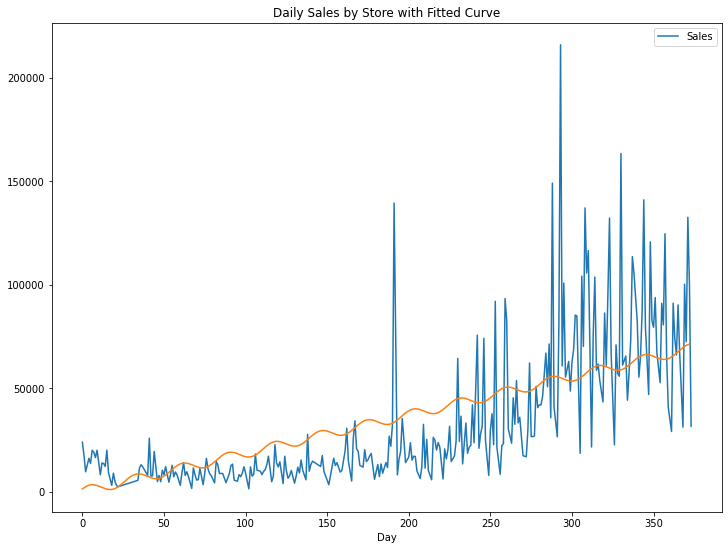

In [43]:
# get sales by store
df_store = df[df.Channel == 'Store']\
    .groupby('InvoiceDay')\
    .agg({'Sales': 'sum'})\
    .reset_index(drop=False)

# add Day column (account for missing date values)
df_store['Day'] = df_store.InvoiceDay.apply(lambda d: (d - df_store.InvoiceDay.min()).days)

# set params
x = df_store.Day.values
y = df_store.Sales

# fit curve, get parameters and accuracy measures
results = fit_curve_func(x, y)

# plot sales, predicted values
print(f"MAPE: {round(results['MAPE'], 2)}")
print(f"RMSE: {round(results['RMSE'], 2)}")
ax = df_store.plot(x='Day', figsize=(12, 9))
ax.set_title("Daily Sales by Store with Fitted Curve")
ax.plot([curve_func(i, *results['params']) for i in range(0, 373)]);

Doesn't look great. We should tune our parameters some to find a better fit. We'll use grid search on a small number of parameters to find a better curve:

In [47]:
from sklearn.model_selection import ParameterGrid

# setup grid
params_grid = {
    'amp': [-100000, -10000, -1000, -100, 0, 100, 1000, 10000, 100000],
    'freq': [-1, -.1, 0, .1, 1],
    'phase': [-10000, -1000, -100, 0, 100, 1000, 10000],
    'trend': [0, 100, 1000]
}

# run grid search
results = []
for params in ParameterGrid(params_grid):
    try:
        result = fit_curve_func(x,y,list(params.values()))
        results.append(result)
    except RuntimeError:
        # NOTE: scipy will throw a RuntimeError if Optimal parameters cannot be found.
        #       Only happens with some parameter combinations.
        print(f"Failed to fit params {params}")

/Users/robert/.pyenv/versions/3.8.2/envs/comoto_takehome/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


MAPE: 40.71
RMSE: 476075492.08
Params:
    amp:	17267.6199
    freq:	0.0155
    phase:	-9994.3542
    trend:	180.7873


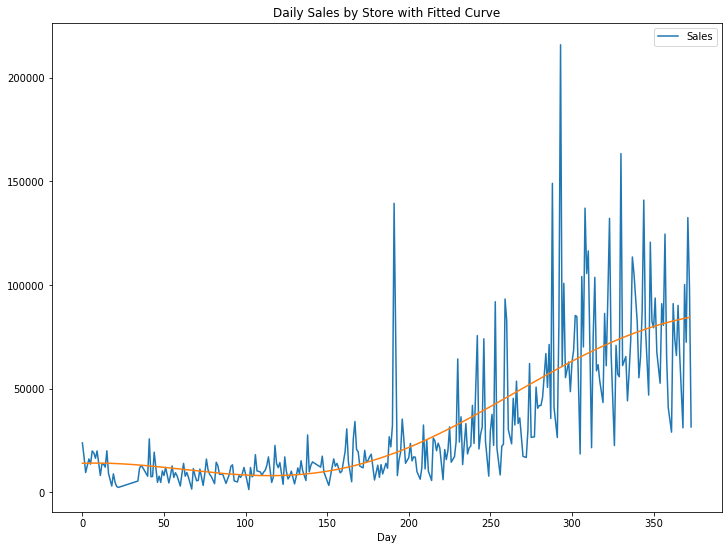

In [50]:
# get params for best fit by RMSE
results.sort(key=lambda r: r['RMSE'])
best_fit = results[0]

# print accuracy metrics, params
print(f"MAPE: {round(best_fit['MAPE'], 2)}")
print(f"RMSE: {round(best_fit['RMSE'], 2)}")
print(f"Params:")
for k,v in zip(params_grid.keys(), best_fit['params']):
    print(f"    {k}:\t{round(v, 4)}")

# plot data and curve
ax = df_store.plot(x='Day', figsize=(12, 9))
ax.set_title("Daily Sales by Store with Fitted Curve")
ax.plot([curve_func(i, *best_fit['params']) for i in range(0, 373)]);

That looks much better, and our accuracy metrics have improved by a large margin. Let's extend the curve to our 90 day forecast window to see if it behaves as expected:

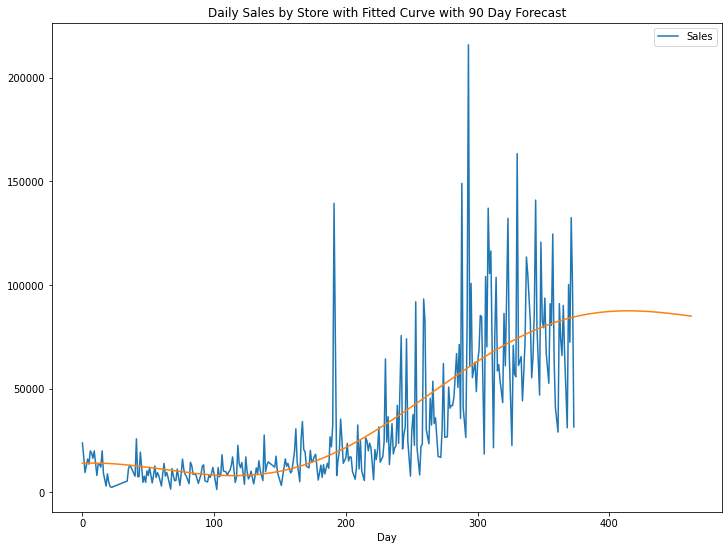

In [53]:
# plot data and curve with forecast
ax = df_store.plot(x='Day', figsize=(12, 9))
ax.set_title("Daily Sales by Store with Fitted Curve with 90 Day Forecast")
ax.plot([curve_func(i, *best_fit['params']) for i in range(0, 463)]);

Much better! The curve exhibits a downward trend throughout the winter months, which is the seasonal trend we expect given the downward trend at the start of our dataset.

Let's try this approach on overall sales and see if it still fits well.

In [54]:
# get daily sales numbers
df_sales = df.groupby('InvoiceDay')\
    .agg({'Sales': 'sum'})\
    .reset_index(drop=False)

# add Day column (account for missing date values)
df_sales['Day'] = df_sales.InvoiceDay.apply(lambda d: (d - df_sales.InvoiceDay.min()).days)

# set params
x = df_sales.Day.values
y = df_sales.Sales

# setup grid
params_grid = {
    'amp': [-100000, -10000, -1000, -100, 0, 100, 1000, 10000, 100000],
    'freq': [-1, -.1, 0, .1, 1],
    'phase': [-10000, -1000, -100, 0, 100, 1000, 10000],
    'trend': [0, 100, 1000]
}

# run grid search
results = []
for params in ParameterGrid(params_grid):
    try:
        result = fit_curve_func(x,y,list(params.values()))
        results.append(result)
    except RuntimeError:
        # NOTE: scipy will throw a RuntimeError if Optimal parameters cannot be found.
        #       Only happens with some parameter combinations.
        print(f"Failed to fit params {params}")

/Users/robert/.pyenv/versions/3.8.2/envs/comoto_takehome/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


MAPE: 40.73
RMSE: 986046574.62
Params:
    amp:	22008.8607
    freq:	-0.0153
    phase:	-99.101
    trend:	315.6731


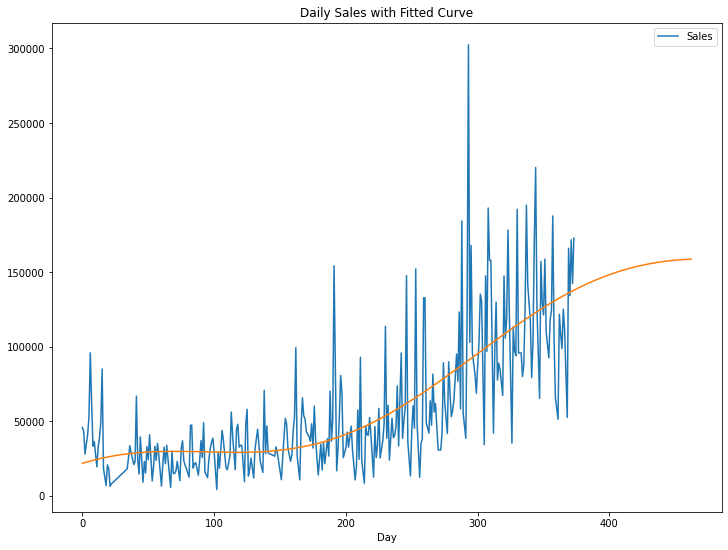

In [58]:
# get params for best fit by RMSE
results.sort(key=lambda r: r['RMSE'])
best_fit = results[0]

# print accuracy metrics, params
print(f"MAPE: {round(best_fit['MAPE'], 2)}")
print(f"RMSE: {round(best_fit['RMSE'], 2)}")
print(f"Params:")
for k,v in zip(params_grid.keys(), best_fit['params']):
    print(f"    {k}:\t{round(v, 4)}")
    
# create series with curve data
curve_data = pd.Series([curve_func(i, *best_fit['params']) for i in range(0, 463)])

# plot sales, predicted values with 90 day forecast
ax = df_sales.plot(x='Day', figsize=(12, 9))
ax.set_title("Daily Sales with Fitted Curve")
ax.plot(curve_data);

Not as well. While the MAPE value is similar to the curve we fit on Sales by Store, the curve doesn't quite exhibit the seasonal behavior we'd expect - sales after the holidays should drop off more drastically. In addition, the RMSE value is much larger than the Store model. With some more tuning, we could likely get it to fit like the curve on Sales by Store above. And the fact that that curve fits well shows that this approach has promise. However, in the interest of time, we'll use this as a final model and move on.

In [67]:
# find forecasted sales amount
sales_forecast = sum(curve_data[-90:])
print(sales_forecast)

13625916.766742969


In [72]:
# find year over year increase in forecast for period
from datetime import timedelta

d1 = df_sales.InvoiceDay.max() - timedelta(days=365)
d2 = d1 + timedelta(days=90)
sales_p1 = df_sales[(df_sales.InvoiceDay >= d1) & (df_sales.InvoiceDay < d2)].Sales.sum()

print(f"Projected year-over-year increase in Sales: {round(sales_forecast / sales_p1, 2) * 100}%")

Projected year-over-year increase in Sales: 779.0


That's far too high, and more than anything else that indicates the model needs more work. Just looking at the data, I'd have expected to see something in the 300-500% range.

## Summary

Given the limited nature of the dataset and its relatively small time window (less than 1 years' worth of data isn't enough to find an accurate estimate for the seasonal effect), I used a sinusoidal curve with a linear trend to create a simple forecast function that should reasonably project sales for the next 90 days.

While it would be worthwhile to explore creating a hierarchical model that forecasts sales by channel, I decided to use one fit to total sales data in the interest of time.

Though the final model doesn't reflect the seasonal trend as accurately as I'd hoped, the model fit to sales by the Store channel shows that the approach shows promise and the model could improve given more tuning.